CIFAR10 CLASSIFCATION PROJECT
<br>How to use this notebook
I recommend looking at the code and the visualizations in the notebook version, but to re-run experiments using command-line argument, please use the .py version of this notebook

<br>How to run standalone? <code>
python cifar10-kmeans-patches-dev.py --help                                # help for all the options
python cifar10-kmeans-patches-dev.py --test                                # for test on pkl results
python cifar10-kmeans-patches-dev.py --train --K 100 --subset 5000  --aug  # for training with different parameters 
</code>


# documentation

## Summary:
I first started with a NN, but I saw that they achieve above 95% accuracy out-of-box on CIFAR10, without any new code on my part. So I decided instead to use the method we learned in class, where I can do some modifications to the initial method.

Relevant articles:
* [An Analysis of Single-Layer Networks in Unsupervised Feature Learning / Adam Coates, Honglak Lee, Andrew Y. Ng.](https://cs.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf)
* [Learning Feature Representations with K-means/ Adam Coates, Andrew Y. Ng.](https://www-cs.stanford.edu/~acoates/papers/coatesng_nntot2012.pdf)
* Zero Component Analysis (ZCA) is explained in Appendix A of https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf




My results:
* K=800, with data-augmentation: duration: 183min, test-accuracy: <b>0.776</b>  (above the article results)
* K=800, without augmentation: train-duration:85min, test-duration: 252s for 10K (avg:0.025s per image). test-accuracy: 0.757-<b>0.762</b> (3 different random seeds)</b>
The 0.762 pkl was attached.



<br>Best results in the articles (graph below taken from the 2011 article)
* K-means (Triangle,  K=4000) 79.6% (article)
* K-means (Triangle , K=1600) 77.9% (article)
* K-means (Triangle , K=800) + Aug:  <b>77.6% (mine. Highher tan the article for same K)</b>
* K-means (Triangle , K=800)  <b>76.2% (mine)</b> looks on par with the results seen in the graph (exact values were not written for K=800).
* Please note that running experiments with higher K were not possible on my 8GB machine. 
<img src="files/k_graphs.jpg">



## Method 
I will describe the mehod here, with relevant parameters and the non-trivial steps.

<br>Step1: unsupervised dictionary learning 
* choose random patches of WxWxD from all images. In our case 6x6x3 was selected.
<br><br>
* preprocess patches: for each patch seperatly (not globaly), do mean-reduction, division by std 
<br>ZCA whitening was applied globally. The goal of this step is to further normalize variance which is not in one of the axis-direction (unlike regular division by std on the axis directions) . <br>Please see the diagram below (after the ZCA code) on a generated 2d data. This extra step is important for the accuracy of the euclidian distance calculation between clusters in the next phase.
<br><br>
* Use KMeans algorithm to find K centroids which are the “main-import-features”. Due to memory constraints, MiniBatchKMeans was used in batches. K, the number of centroids is a parameter in the range 50–4000 (higher is better, but slower and consumes more memory)
<br><br>

Step 2: supervised discriminator-learning
* for each image, densly extract all patches of WxWxD (including overlaps). Note: using stride>1 reduce accuracy (but saves time). It was suggested in the article that the number of extracted features from each image should be very high, and accuracy suffers when using smaller numbers.  Interest point detectors will be more sparse, and hence not used. Another drawback of interest-point detector is ignorning patches which have almost no gradiant like blue-sky/water, which can be usefull in this dataset.
<br><br>
* apply the same preprocessing which was fitted as stage-1.
<br><br>
* represent each patch using the learned dictionary as a K-dimension vector using KMeans, in two ways: <br>"hard" mapping finds the closest centroid (calculate distance to all centroids, return closest and ignore the rest) which return a one-hot-encoded vector , for example [0...,0,1,0,...,0] 
<br> "soft" mapping (named "triangle" in the article) performs better: calculate distance to all centroids, finds the mean distance. Discard the distances above the mean and keep the difference to the mean in the result.<br> for example if distances are 15,25,160,200 mean is 100. vector will be [100-15=85,100-75=25,0,0]
<br><br>
* combine to one vector, using a sum of all the descriptors. When using a hard-match and summing the descriptors, we get the histogram of the features.
<br> When using the “soft” version, you can think of this, intuitively, as smoothed histogram.
<br>spatial-pooling: We assume that features in different locations (top vs bottom, left vs right), have a unique set of features. Thus instead of summing all the descriptors together into one histogram of size K, we divide the image into 4 quarters and sum over each quarter seperatly. To get the final vector, we concatenate the results of the 4 zones. Thus each image is represented by a vector of size 4xK.
<br><br>
* Learn an SVM classifier (best parameters found using Cross-validated GridSearch). Note that before this stage, we will not do an extra normalization/whitening of the histogram itself (found to get worse results)
<br><br>
Extra:
* Adding data-augmentation, of reflection of the y-axis, create a dataset of 100K instead of 50k images (for each image, add the image and it's reflection). This upgrades the accuracy in +1.5-2% beyond the article results. 

* <b>Please note an issue:</b>
While testing ZCA on a generated dataset and very close to the deadline, I saw that I had an implementation bug on the ZCA (I divided by shape[1] instead of shape[0]). The actual result of this implementation difference is of multiplication by scalar.
But after changing this, a large amount of settings need to be re-tested (svm grid-search, epsilons for normalizations etc). Thus I kept the parameters and the division by shape[1]. 


## Comparative experiments 

<br>The following modifications were done to the basic Bag-of-features algorithm. The accuracy was tested on a mini-experiments ( using only K=100 and 10% of the data).  These modifications were suggested in the article.
* ZCA vs no-ZCA preprocessing  : + 3-4%  
* Soft vs Hard representation  : + 5%
* Spatial pooling of 2x2 quarters : + 2-3%  

The following modification was not done in the article:
* Train augment   : + 1.5-2%
* Spatial Pooling:  (accuracy loss. not used in the final version) I have conducted few experiments with a 2 windows, upper and lower only, ignoring left and right sides, as intuitively I thought the right/left windows should not matter. After testing, I saw it actually caused a downgrade of 2.5%, which means it does matter in this sepcific dataset.
* Spatial Pooling vector: (accuracy loss. not used in the final version)  Instead of using a vector with histogram per zone, I added a 5th "zone" which was the whole image, meaning the end-results vector was 5*K instead of 4*K. After testing, I saw it actually casused 1% downgrade.




## zca

0.0707076349958
The red and green points are in the same euclidian distances(!) in the original graph
Note that regular scaling ignores the co-variance and thus scale only in the x,y axis directions
PCA/ZCA remove the correlation and thus enable to better normalize the variance
ZCA is similiar to PCA(whiten=True) but conserve, as best possible, the distances to the original plot (see green/red point location is close to origianl)


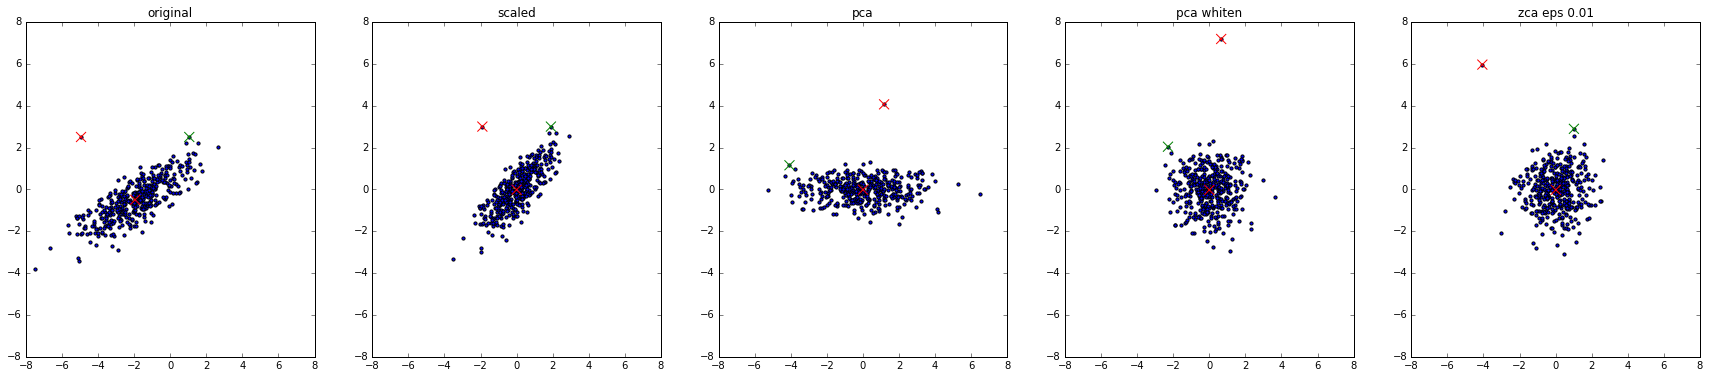

In [1]:
from __future__ import print_function,division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



class Whitener:
    def __init__(self,eps=0.01,skip=False):
        self.eps = eps
        self.skip = skip

    def zca(self,A):
        ''' We aim to find a linear transformation W of X, such that the cov() on the transformed result of X will be diagonal. 
            We add two more restrictions:
            1. The co-variance result should be close to the identity (diagnoal restricted to 1's). 
            2. W should be symetric W = W.T
            with these restirctions, the math expression can be found at : (see the formula development at: page 48 at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) 
        '''
        #Issue here! proper usage of ZCA requires dividing by A.shape[0] and not A.shape[1],  the end result is multiplying by scalar.
        AtA = np.dot(A.transpose(),A) / A.shape[1]  
        #svd
        U,s,V = np.linalg.svd(AtA, full_matrices=True)
        
        self.W =  np.dot(   np.dot(U
                                       ,np.diag(1.0/np.sqrt(s+ self.eps))
                                      )
                                ,U.T) 
        return np.dot(A,self.W)

    def fit_transform(self,X):
        """
            X: array of flattened array, with N x D , where N=#images D=#all pixels(on cifar, 32x32x3=3072 flat)
            usage: fit_transform should be called once,on train-set then call transform on test set
        """
        original_shape = X.shape
        #reduce mean from each pixel seperatly (1st pixel of the 3072 in cifar has one mean, 2nd pixel has another...)
        self.mean_vec =X.mean( axis=0)
        X -= self.mean_vec
        X = self.zca(X)
        return X
    
    def transform(self,X):
        """
            X: array of flattened array, with N x D , where N=#images D=#all pixels(on cifar, 32x32x3=3072 flat)
            usage: fit_transform should be called once,on train-set then call transform on test set
        """
        #reduce mean from each pixel seperatly (1st pixel of the 3072 in cifar has one mean, 2nd pixel has another...)
        X -= self.mean_vec
        #use precalculated zca matrix
        X = np.dot(X,self.W)
        return X
 


def plot_zca_example():    
    import sklearn.decomposition
    
    def plot(X,title,i):
        #plt.subplot(1,5,i)
        ax1 = plt.subplot(1,5,i)
        plt.scatter(X[0],X[1],c='b',s=10)
        plt.scatter(X[0,-3:],X[1,-3:],c='grr',s=100,marker='x')
        
        ax1.set_xlim([-8, +8])
        ax1.set_ylim([-8,+8])
        plt.title(title)
    
    N=20*20
    X = np.random.normal(loc=-2,scale=1.6,size=(2,N))
    # override Y using aX+b
    X[1:]=X[:1,]* 0.5 + np.random.normal(0.5,0.6,(1,N)) 
    # the last 3 will be overrided as special points.  The mean and two points with same distance to it
    X[:,-1] = X[:N-3].mean(axis=1) #mean point 
    X[:,-2] = X[:,-1] + [-3,+3]    #mean point -3,+3  in-the-cluster
    X[:,-3] = X[:,-1] + [+3,+3]    #mean point -3,+3  outlier
    
    plt.figure(figsize=(30,6))
    plot(X,'original',1)
    

    plot(sklearn.preprocessing.StandardScaler().fit_transform(X.T).T,'scaled',2)
    plot(sklearn.decomposition.PCA(whiten=False).fit_transform(X.T).T,'pca',3)
    plot(sklearn.decomposition.PCA(whiten=True).fit_transform(X.T).T,'pca whiten',4)
    plot(Whitener().fit_transform(X.T).T*10*1.414,'zca eps 0.01',5)
    print (Whitener().fit_transform(X.T).T.std())

    #see difference between pca-whitening and zca at: https://stats.stackexchange.com/questions/117427/what-is-the-difference-between-zca-whitening-and-pca-whitening
    print ('The red and green points are in the same euclidian distances(!) in the original graph')
    print ('Note that regular scaling ignores the co-variance and thus scale only in the x,y axis directions')
    print ('PCA/ZCA remove the correlation and thus enable to better normalize the variance')
    print ('ZCA is similiar to PCA(whiten=True) but conserve, as best possible, the distances to the original plot (see green/red point location is close to origianl)')
    plt.show()

plot_zca_example()
    
    

# Step 1: unsupervised dictionary learning 


## load cifar10

In [2]:
import cPickle
def cifar10():
    def load_convert_cifar10(filenames):
        dics = []
        for filename in filenames:
            with open(filename, 'rb') as f:
                dics.append(cPickle.load(f)) # keys are ['data', 'labels', 'batch_label', 'filenames']
        Y = np.concatenate( [f['labels'] for f in dics]).reshape([-1, 1])
        X = np.concatenate( [f['data'] for f in dics]).reshape([-1, 3, 32,32]).transpose([0, 2, 3, 1])
        return X,Y

    x_train,y_train = load_convert_cifar10(['./data/data_batch_' + str(i) for i in range(1,6)])
    x_test,y_test = load_convert_cifar10(['./data/test_batch'])
    labels_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
    return x_train,y_train, x_test,y_test,labels_names

x_train,y_train, x_test,y_test,labels_names = cifar10()
print (x_train.shape,x_train.dtype)
print (y_train.shape)


(50000L, 32L, 32L, 3L) uint8
(50000L, 1L)


## extract_random_patches

In [3]:
import math
from numpy.random import randint

def extract_random_patches(x_train,features_per_image,W):
    '''
    x_train: images of shape 4d, for example cifar10 50Kx32x32x3 . type is ignored.
    features_per_image: average number of features per image to extract
    W: each patch will be a square W*W*d
    
    returns: a 2d array of shape M*(W*W*D) of same type, where M is numbers-of-images*features_per_image
    
    usage:
    >>> extract_random_patches(x_train[:10],100,5).shape
    (100L, 75L)
    '''
    M = x_train.shape[0] * features_per_image
    patches = np.empty(shape=(M,(W*W*x_train.shape[3])),dtype=np.float32)

    sample = randint(0,x_train.shape[0],size=M) #low (inclusive) to high (exclusive).
    i_pixel= randint(0,x_train.shape[1] - W+1, size= M)
    j_pixel= randint(0,x_train.shape[2] - W+1, size= M)
    for m in range(M):
        patch=x_train[sample[m] ,
                      i_pixel[m]: W + i_pixel[m],
                      j_pixel[m]: W + j_pixel[m],
                      :].ravel()
        patches[m] = patch
    return patches

def enhanced_imshow(img) :
    """ 
    images after normalization (mean,std) will be in the range of [-v,+v] , where most pixels are in [-1,+1]
    plt expect values between 0 and 1, so we check min, and add it:  [-v,+v]->[0,2v]  then divide by min+max ->[0,1]
    """
    if img.dtype not in [np.float16, np.float32,np.float64]:
        raise ValueError(str(img.dtype) + 'only np.float32 is supported. if you have uint8 consider using np.astype(np.float32)/255.0')
    img=(img - img.min()) / (img.max() - img.min())
    plt.imshow( img)



def visualize_patches(patches,max_to_show=20,cols=10,D=3):
    '''
        reshape the patches vector into WxWxd and show few of them
    '''
    max_to_show= min(max_to_show,patches.shape[0])
    max_rows = int(math.ceil(max_to_show/cols))
    
    plt.figure(figsize=(max_to_show/max_rows*6, 4*max_rows)) #last may be too much
    for i in range(max_to_show):
        plt.subplot(max_rows,cols,i+1)
        W= int(math.sqrt(patches.shape[1]/D))
        #plt.imshow(patches[i].reshape((W,W,D)))
        enhanced_imshow(patches[i].reshape((W,W,D)))
    plt.show()




## Preprocess each patch

In [4]:
def sampleNormalize(patches,normalize_eps=10): 
    """
        patches: array of shape M x patch_size 
        apply for each patch by itself, mean reduction and division by std
        returns: preprcoessed array of the same size
    """ 
    patches *=255.0  # fixes the zca range issue
    m = patches.mean(axis=1, keepdims=True)  # M,W -> M,1 with 1 mean per sample (mean of all RGB pixels togeter)
    patches= patches - m
    std_with_eps = np.sqrt(patches.var(axis=1, keepdims=True)+normalize_eps)
    patches = patches / std_with_eps
    patches /= 255.0  #convert it back to the same range
    return patches




# Step 2: supervised discriminator-learning


## codebook





In [5]:
import sklearn
import sklearn.cluster

class Codebook:
    def __init__(self,K,representation_type,patch_size=6*6*3,random_state=666):
        """
        K: number of clusters
        representation_type: "hard" means one-hot-encoding of the closest cluster index, for exmaple  [0,0,0,1] means closest cluster index is the last.
                             "soft" will return the distances to the nearest clusters, as long as they are above the mean. 
                             for example: if the distances are [4,6,1.5,0.5] mean distance=3.0 , thus result is [0,0,1.5,2.5] which is max(0,mean - distance)
                             
        usage:
            cb = Codebook(100,'hard')
            cb.fit(...) called once
            then call: cb.transform(...)
        """
        self.K = K
        self.representation_type = representation_type
        
        #MiniBatchKMeans allows batching 
        self.kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=K, random_state=random_state)  
        self.first_run = True

        
    def partial_fit(self, patches):
        """
            patches: array of shape: patch x patch_size
            returns: nothing
            
            don't use this if fit() was used
            
        """
        self.kmeans.partial_fit(patches)
        
    def fast_transform(self, patches):
        """
            patches: array #patches x patch_size
            returns: array of shape: #patches x kmeans.clusters
        """
        
        distances = self.kmeans.transform(patches)  #returns patchesxK matrix where values are distances

        if self.representation_type=='hard':
            # first step, transform patchs(Nxpatch_size) into zero-hot-encodings (NxK)
            representations = np.zeros_like(distances)
            if self.first_run: print ('representations',representations.shape,'patches',patches.shape)
            min_distances = distances.argmin(axis=1)
            #print ('min_distances',min_distances.shape)
            representations[np.arange(0,len(patches)),  #all rows
                            min_distances]=1            #cols

        elif self.representation_type=='soft':
            mean_distances = distances.mean(axis=1).reshape(distances.shape[0],1)
            representations = mean_distances - distances
            representations[representations<0]=0
        else:
            raise ValueError('type not implemented'+ self.representation_type)

        if self.first_run:
            #print ('representations', representations.shape)
            self.first_run = False

        return representations
    
    

def test():    
    a= np.arange(100).reshape((20,5))
    cb = Codebook(3,representation_type='hard',patch_size=5)
    cb.partial_fit(a)
    print('hard',cb.fast_transform(a[:2]))
    
    cb = Codebook(3,representation_type='soft',patch_size=5)
    cb.partial_fit(a)
    print('soft',cb.fast_transform(a[:2]))
    

#test()        


## represent single img

In [6]:
from sklearn.feature_extraction import image


def fast_represent(all_data,whitener,cb,W,K,spatial_pooling,random_state=666,verbose=False):
    """
        all_dataL samokes of NxWxWxD
        whitener - pre-fit whitener (ZCA).
        cb - pre-fit codebook (kmeans)
        W  - patch size
        K  - #centroids in cb
        spatial_pooling - tuple of zone_x,zone_y : (2,2) means 4 quaters.  1x1 means the whole image.  (2,1),(1,2) is also possible.
        
        returns: an array of #images x K*#zones
        
        extract dense patches from al images, apply normalize and whitening, convert each patch into a K-size vector, and 
        then sum each set of vectors according to it's zone, for example in (2x2) spatial-pooling, there will be 4 zones.
        The end results of each image is a vector of size K*#zones , and the returned value is a matrix of #images x K*#zones
    """
    ex = image.PatchExtractor((W, W),random_state=random_state)
    all_representation=np.empty(shape=[len(all_data),K*spatial_pooling[0]*spatial_pooling[1]],dtype=np.float32)
    
    #run with batches, due to memory constraints
    BATCH=500
    for start_img in range(0,len(all_data),BATCH):
        max_curr = min(len(all_data),start_img+BATCH)
        data = all_data[start_img:max_curr]
        
        # all actions will be done seperatly on the different spatail zones
        repr_list=[]
        zone_size_x = int((data.shape[1]-W+1)/spatial_pooling[0]) #e.g. (32-30)/2=1
        zone_size_y = int((data.shape[1]-W+1)/spatial_pooling[1]) #e.g. (32-30)/2=1
        zone_counter=0
        for ix,zone_x in enumerate(range(0,spatial_pooling[0]*zone_size_x,zone_size_x)):
            for iy,zone_y in enumerate(range(0,spatial_pooling[1]*zone_size_y,zone_size_y)):
                patches = ex.transform(data[:,
                                            zone_x:zone_x+zone_size_x+W-1,
                                            zone_y:zone_y+zone_size_y+W-1,
                                            :]) #example: 4, spatial=2, 3x3patches
                
                if verbose and ix==0 and iy==0 and zone_counter==0:
                    print ('patches : ',patches.shape)
                
                patches = patches.reshape(patches.shape[0],np.product(patches.shape[-3:]))

                patches = sampleNormalize(patches)

                patches = whitener.transform(patches)

                representations= cb.fast_transform(patches)
                
                # representations are now #patches*K for each zone, we want to sum over all images
                patches_per_images=int(patches.shape[0]//data.shape[0])
                sum_over_zone= representations.reshape(data.shape[0],patches_per_images,representations.shape[1]).sum(axis=1)
                #for example ,[2,1] means there are two zones, which should be summed for k=100 , 0:100 100:200
                all_representation[start_img:max_curr,zone_counter*K:(1+zone_counter)*K]=sum_over_zone
                
                zone_counter+=1
                
    return all_representation
    
        

## augment
This is an optional step. A simple augmentation scheme is reflections over the y-axis. This is usefull as cars/frogs can be photographed when they address the left or right direction. There is almost no chance in the realworld for reflection over the x-axis (frog updside-down)


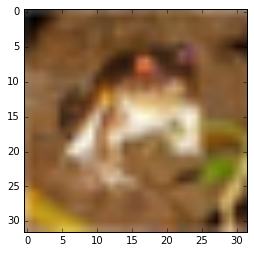

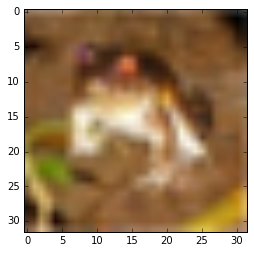

In [7]:
def augment(X,Y):
    '''
     reflections over the y-axis.
     returns: an array with twice the size (X,Y)
    '''
    X_aug= np.empty(shape=(2*X.shape[0],X.shape[1],X.shape[2],X.shape[3]),dtype=X.dtype)
    Y_aug= np.empty(shape=(2*Y.shape[0],Y.shape[1]),dtype=Y.dtype)
    
    X_aug[0:X.shape[0]] = X
    X_aug[X.shape[0]:]  = X[:,:,::-1,:]
    
    Y_aug[0:Y.shape[0]] = Y
    Y_aug[Y.shape[0]:]  = Y
    return X_aug,Y_aug

def test():    
    X=  x_train[:10]    
    plt.imshow(X[0])
    plt.show()
    X_aug,Y_aug= augment(X,y_train[:10])    
    plt.imshow(X_aug[10])
    plt.show()
test()

# experiment

In [10]:
import sklearn
import sklearn.ensemble
import time
import math

def run_experiment(experiment_params,verbose=False): 
    def mem_str(A_2d):
        return str(A_2d.shape[0]*A_2d.shape[1]*4/(1024*1024*1024))+'GB'
    
    start_time = time.time()
    
    # extract parameters from the params dictionary
    RANDOM_STATE=experiment_params['random_state']
    W= experiment_params['W']
    K = experiment_params['K']
    spatial_pooling = experiment_params['spatial_pooling']
    cb_subset = experiment_params['cb_subset']
    subset= experiment_params['subset']
    image_batch_size = experiment_params['im_batch'] 
    features_per_image = experiment_params['features_per_image']
    test_subset = experiment_params['subset']

    # set a random seed for repeatable accuracy results between runs
    np.random.seed(seed=RANDOM_STATE)
    

    if verbose: print ('\n### loading cifat10 from data folder')
    x_train,y_train, x_test,y_test,labels_names = cifar10()
    if (experiment_params['aug']):
        print ('performing augmentation')
        x_train,y_train = augment(x_train[:subset],y_train[:subset])
        cb_subset = 2*cb_subset
        subset= 2*subset

    
    if verbose: print ('\n### extract_random_patches')
    cb = Codebook(K,experiment_params['repr_type'],random_state=RANDOM_STATE)
    whitener = Whitener(eps=experiment_params['zca_eps'], skip=experiment_params['zca_skip'])

    # Due to memory limitations, we loop on the train data in multiple batches
    total_patches = cb_subset * features_per_image                     #for example 50K*100=5M
    total_steps = int(math.ceil(total_patches/image_batch_size))        # for example 5M/500K = 10 
    features_per_image_each_step = int(math.ceil(total_patches/total_steps/cb_subset))  #for example 1000
    for i in range(total_steps):
        
        patches= extract_random_patches(x_train[:cb_subset],features_per_image_each_step,W)
        
        if verbose: 
            print ('# batch run number '+str(i) + 'x_train[:cb_subset] {} {}'.format(len(x_train[:cb_subset]),features_per_image_each_step),
                   patches.shape,patches.dtype,'mem usage:'+mem_str(patches))  #500Kx108
        if verbose: print ('\n# preprocess current batch')
        # first apply sample normalization (each sample calculates it's own mean, std)
        patches= sampleNormalize(patches)
        if verbose and i==0: 
            visualize_patches(patches,max_to_show=10)
        if i==0:
            patches = whitener.fit_transform(patches) #fit on the first batch
        else:
            patches = whitener.transform(patches)
        if verbose and i==0: 
            print ('after whitening:')
            visualize_patches(patches,max_to_show=10)
        
        if verbose: print ('\n### codebook fit using kmeans')
        cb.partial_fit(patches)

    if verbose: 
        print ('sample codebook patches')
        visualize_patches(cb.kmeans.cluster_centers_,cols=30,max_to_show=200)

    if verbose: print ('\n### second stage: extract patches and represent using codebook')
    train_representation= fast_represent(x_train[:subset],whitener,cb,W,K,spatial_pooling,random_state=RANDOM_STATE)
    if verbose: print ('train_representation shape ',train_representation.shape)
    

    if verbose: print ('model input:',train_representation.shape,y_train[:subset].shape,'mem usage:'+mem_str(train_representation))
    
        
    cls='linear_svc'
    model = None

    if (cls=='grid_search'):  #usefull for grid search
        parameters = {'C': [0.5,10.0,100.0],
                      'dual' : [False] #True is always bad
                     }
        model = sklearn.model_selection.GridSearchCV(sklearn.svm.LinearSVC(random_state=RANDOM_STATE), parameters, cv=3,
                           scoring='accuracy',n_jobs=2,return_train_score=True)
        model.fit(train_representation[:subset], y_train[:subset].ravel())
        print(model.best_score_,model.best_params_)
        best_model = model.best_estimator_
        print ('training accuracy',best_model.score(train_representation, y_train[:subset]))
        print(model.cv_results_)
    elif cls=='linear_svc':  #for 5000 0.7648/0.5482  17.9s  0.7022/0.521
        model= sklearn.svm.LinearSVC(C=experiment_params['SVM_C'],dual=False,random_state=RANDOM_STATE)
  

    model.fit(train_representation[:subset], y_train[:subset].ravel())
    train_score = model.score(train_representation, y_train[:subset].ravel())
    
    if verbose: print ('\n### test phase')
    test_representation= fast_represent(x_test[:test_subset],whitener,cb,W,K,spatial_pooling,random_state=RANDOM_STATE)
    if verbose: print (test_representation.shape,x_test[:test_subset].shape)
    test_score = model.score(test_representation, y_test[:test_subset].ravel())
    
    elapsed_time = time.time() - start_time
    return train_score,test_score,elapsed_time,[ model,cb, whitener] 



## train


### loading cifat10 from data folder

### extract_random_patches
# batch run number 0x_train[:cb_subset] 25000 20 (500000L, 108L) float32 mem usage:0.201165676117GB

# preprocess current batch


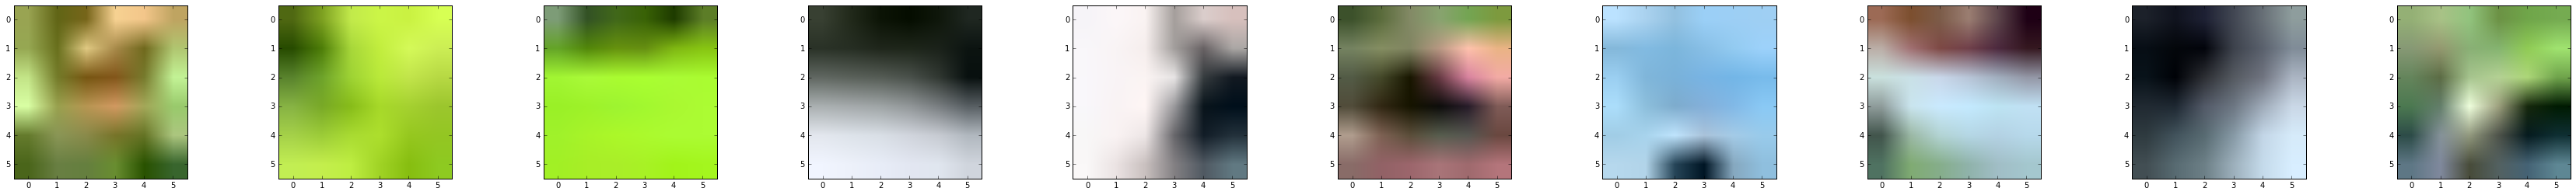

after whitening:


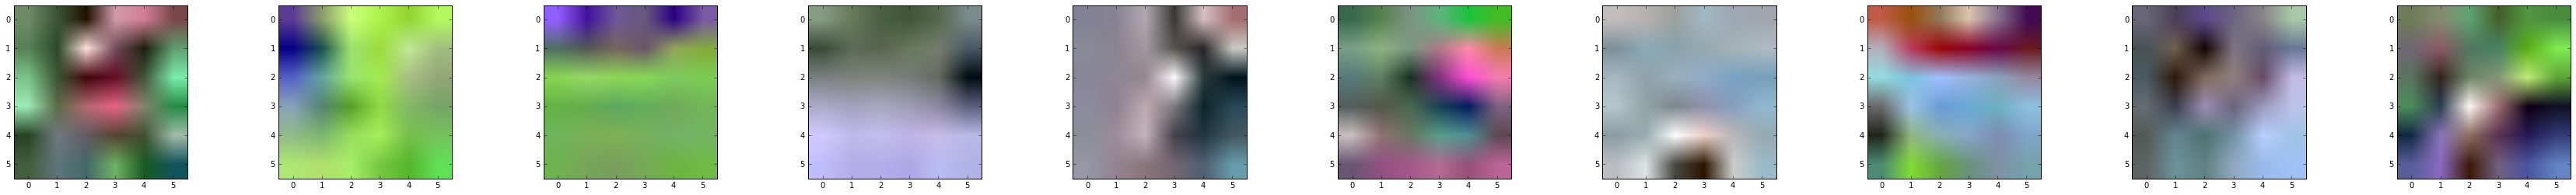


### codebook fit using kmeans
# batch run number 1x_train[:cb_subset] 25000 20 (500000L, 108L) float32 mem usage:0.201165676117GB

# preprocess current batch

### codebook fit using kmeans
# batch run number 2x_train[:cb_subset] 25000 20 (500000L, 108L) float32 mem usage:0.201165676117GB

# preprocess current batch

### codebook fit using kmeans
# batch run number 3x_train[:cb_subset] 25000 20 (500000L, 108L) float32 mem usage:0.201165676117GB

# preprocess current batch

### codebook fit using kmeans
# batch run number 4x_train[:cb_subset] 25000 20 (500000L, 108L) float32 mem usage:0.201165676117GB

# preprocess current batch

### codebook fit using kmeans
sample codebook patches


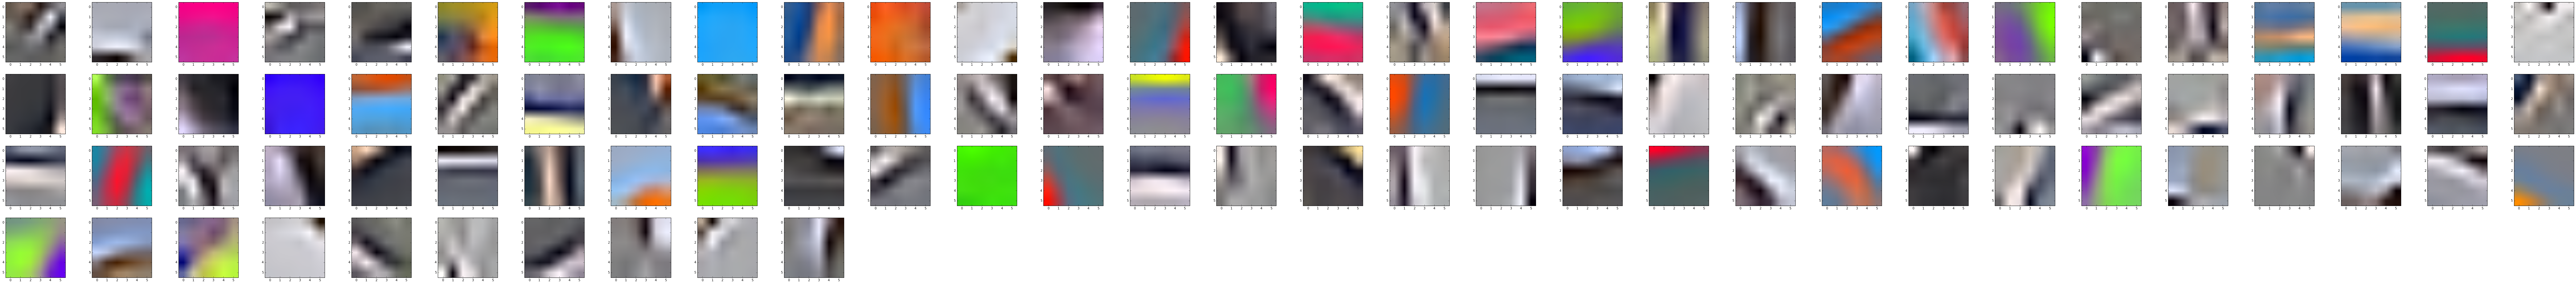


### second stage: extract patches and represent using codebook
train_representation shape  (5000L, 400L)
model input: (5000L, 400L) (5000L, 1L) mem usage:0.00745058059692GB

### test phase
(5000L, 400L) (5000L, 32L, 32L, 3L)

 {'subset': 5000, 'W': 6, 'K': 100, 'spatial_pooling': [2, 2], 'zca_eps': 0.01, 'SVM_C': 0.5, 'features_per_image': 100, 'repr_type': 'soft', 'aug': None, 'l2_norm': False, 'cb_subset': 25000, 'random_state': 666, 'im_batch': 500000, 'zca_skip': False} 
  time//train/test 137.940000057 0.7644 0.6018
3


In [11]:
from sklearn.externals import joblib
import argparse

train,test=True,True
test_score=None


#note : the parametes here are for a quick sample run, which can finish in 2min. for subset of 50000 and K 800, runtime is few hours
if train:
    parameters_l=[
        {'W':6 , 'cb_subset':2500*10, 'subset':5000*1, 'features_per_image':100, 'K':100, 'spatial_pooling':[2,2], 'zca_skip':False,
         'zca_eps':0.01, 'repr_type':'soft','SVM_C':0.5,'im_batch':25000*100//5,'aug': None, 'l2_norm':False, 'random_state':666},   #'reflect'
        ]  

    transformers,test_score= None,None
    for parameters in parameters_l:
        train_score,test_score,duration, transformers = run_experiment(parameters,verbose=True)
        print ('\n',parameters,'\n  time//train/test',duration,train_score,test_score) 
        # save 4 pickles, for svm and other transformers. expect files like:  pkl/cifar10_cb_75.50.pkl
        names = ['svm','cb','zca']
        for i in range(len(transformers)):
            joblib.dump(transformers[i], open('pkl/cifar10_{}_{:0.3f}.pkl'.format(names[i],test_score), 'wb'))
        


Note that the above is a run with K=100 and 10% of the data (result is 60% accuracy.  below you can upload a pkl file on the full data with K=800)

# Load and score

In [12]:
# load those files into transformer_l variable
# This can be used as a STANDALONE!!!
from sklearn.externals import joblib



_,_, x_test,y_test,labels_names = cifar10()
test_representation=None
test_score=0.762

if test:
    names = ['svm','cb','zca']
    if not test_score:
        loaded_pkl_test_score=0.762
    else:
        loaded_pkl_test_score = test_score
    transformers_l=[]
    for i in range(len(names)):
        transformers_l.append( joblib.load('pkl/cifar10_{}_{:0.3f}.pkl'.format(names[i],loaded_pkl_test_score)))
    svm_l , cb_l ,zca_l = transformers_l

    # redo the test with load pickles
    %time test_representation= fast_represent(x_test,zca_l,cb_l,W=6,K=800,spatial_pooling=[2,2])
    %time actual_test_score = svm_l.score(test_representation, y_test.ravel())
    print ('actual test_score',actual_test_score)

    #confusion matrix
    print ('\nconfusion matrix:')
    cm= sklearn.metrics.confusion_matrix(y_test.ravel(), svm_l.predict(test_representation), labels=None, sample_weight=None)
    cm_str= np.empty((11,11),np.dtype('U4'))
    cm_str[1:,1:]=cm
    for i in range(len(labels_names)):
        cm_str[0,1+i]=labels_names[i]
        cm_str[i+1,0]=labels_names[i]
    np.set_printoptions(linewidth=200,formatter={'all':lambda x: '{:4}'.format(x)})
    print(cm_str)

    print ('\nclassification_report:')
    from sklearn.metrics import classification_report
    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(y_test[:len(test_representation)].ravel().ravel(), svm_l.predict(test_representation), target_names=labels_names))




Wall time: 3min 47s
Wall time: 3.14 s
actual test_score 0.7618

confusion matrix:
[[     airp auto bird cat  deer dog  frog hors ship truc]
 [airp 795  17   38   26   11   5    10   15   57   26  ]
 [auto 26   855  5    14   4    7    3    6    22   58  ]
 [bird 55   8    634  52   74   52   74   25   13   13  ]
 [cat  21   12   63   591  51   149  56   23   11   23  ]
 [deer 12   8    46   38   729  34   50   59   16   8   ]
 [dog  9    4    47   147  41   671  27   35   9    10  ]
 [frog 7    3    37   31   26   24   852  11   2    7   ]
 [hors 16   5    31   40   45   52   8    781  8    14  ]
 [ship 52   28   13   10   8    2    5    2    858  22  ]
 [truc 26   55   7    13   6    6    9    10   16   852 ]]

classification_report:
             precision    recall  f1-score   support

   airplane       0.78      0.80      0.79      1000
 automobile       0.86      0.85      0.86      1000
       bird       0.69      0.63      0.66      1000
        cat       0.61      0.59      0.60